# Starting with Statistical Analysis (Price Based)
##### In this notebook we will only use the statistical methods to find out the best statistical model that predicts the future market behavior.
In this note, we will start with traditional `AR`, `MA` and the combination of two `ARMA` model.
We are here to find out the parameters or lags for these models and then we will just put those parameters to the `ARIMA` model with an extra parameter which is responsible for integration.

#### Step 0: Import Necessary Packages and Setup Meta Information Flow

In [151]:
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats.distributions import chi2
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Step 1: Import the final csv and process it further

Import the final csv file

In [70]:
df = pd.read_csv("../data/dal_final.csv")
df.head()

,Date,Close,Volume
0,2007-06-01,16.945208,2299400.0
1,2007-06-04,16.329809,5692700.0
2,2007-06-05,16.425148,4510000.0
3,2007-06-06,16.407816,2595300.0
4,2007-06-07,16.017773,3062100.0


Perform a quick EDA

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4280 non-null   object 
 1   Close   4280 non-null   float64
 2   Volume  4280 non-null   float64
dtypes: float64(2), object(1)
memory usage: 100.4+ KB


As we see above, there is no null values and all other values are in 64 bit floating point format.

Create Index for the Dataframe

In [72]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [73]:
df.shape

(4280, 2)

Implement a dicky-fuller testing function for stationarity

In [74]:
def augmented_dicky_fuller_test(data):
    result = sm.tsa.stattools.adfuller(data)
    data = [{
        "ADF_STATISTIC": f"{result[0]:.4f}",
        "P-VALUE": f"{result[1]:.4g}",
        "LAG": result[2],
        "Observations": result[3],
        "1%": f"{result[4]['1%']:.4f}",
        "LEFT_OF_1_PCT": result[0] < result[4]['1%'],
        "5%": f"{result[4]['5%']:.4f}",
        "10%": f"{result[4]['10%']:.4f}"
    }]
    return tabulate(data, headers="keys", tablefmt="pretty")

In [75]:
# test the Closing Price aka market price
print(augmented_dicky_fuller_test(df['Close']))

+---------------+---------+-----+--------------+---------+---------------+---------+---------+
| ADF_STATISTIC | P-VALUE | LAG | Observations |   1%    | LEFT_OF_1_PCT |   5%    |   10%   |
+---------------+---------+-----+--------------+---------+---------------+---------+---------+
|    -1.4093    | 0.5778  | 11  |     4268     | -3.4319 |     False     | -2.8622 | -2.5671 |
+---------------+---------+-----+--------------+---------+---------------+---------+---------+


In [76]:
# test the price volume
print(augmented_dicky_fuller_test(df['Volume']))

+---------------+-----------+-----+--------------+---------+---------------+---------+---------+
| ADF_STATISTIC |  P-VALUE  | LAG | Observations |   1%    | LEFT_OF_1_PCT |   5%    |   10%   |
+---------------+-----------+-----+--------------+---------+---------------+---------+---------+
|    -4.9787    | 2.446e-05 | 25  |     4254     | -3.4319 |     True      | -2.8622 | -2.5671 |
+---------------+-----------+-----+--------------+---------+---------------+---------+---------+


As we can see, `Close` is non-stationary in nature and `Volume` is stationary. So, we don't need to go hard on `Volume` data. And let's not indulge ourselves in doing volumatric analysis.

Let us see the seasonal decomposition of the `Close` data.

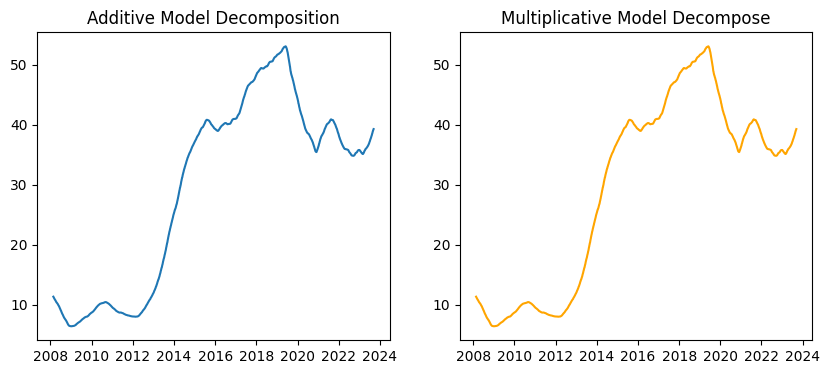

In [77]:
# Understanding Trends
result_additive = sm.tsa.seasonal_decompose(df['Close'], model="additive", period=365)
result_multiplicative = sm.tsa.seasonal_decompose(df['Close'], model="multiplicative", period=365)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(result_additive.trend)
ax[0].set_title("Additive Model Decomposition")
ax[1].plot(result_multiplicative.trend, color="orange")
ax[1].set_title("Multiplicative Model Decompose")
plt.show()

As the above graph suggests, both the additive and multiplicative graph shows trendy nature of the closing prices. And the thing is, the prices are on up trend if we consider overall visuals.
We must now de-trend the data to make it feedable to the stats model.

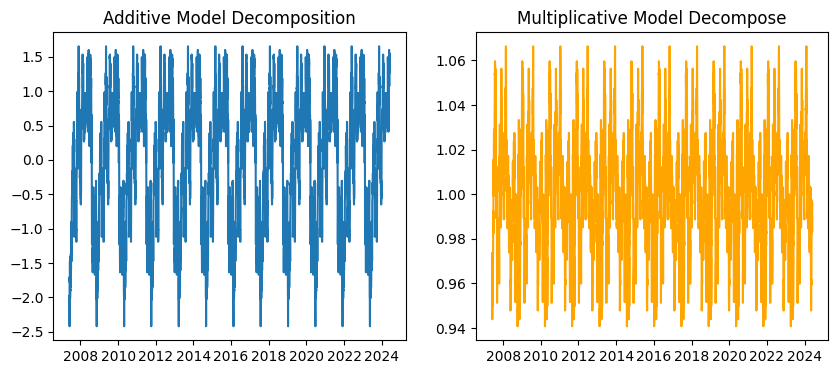

In [78]:
# Understanding Seasonality
result_additive = sm.tsa.seasonal_decompose(df['Close'], model="additive", period=365)
result_multiplicative = sm.tsa.seasonal_decompose(df['Close'], model="multiplicative", period=365)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(result_additive.seasonal)
ax[0].set_title("Additive Model Decomposition")
ax[1].plot(result_multiplicative.seasonal, color="orange")
ax[1].set_title("Multiplicative Model Decompose")
plt.show()

As the graphs tell, both of them show significant seasonal appearences. We must eliminate the seasonality via differencing.

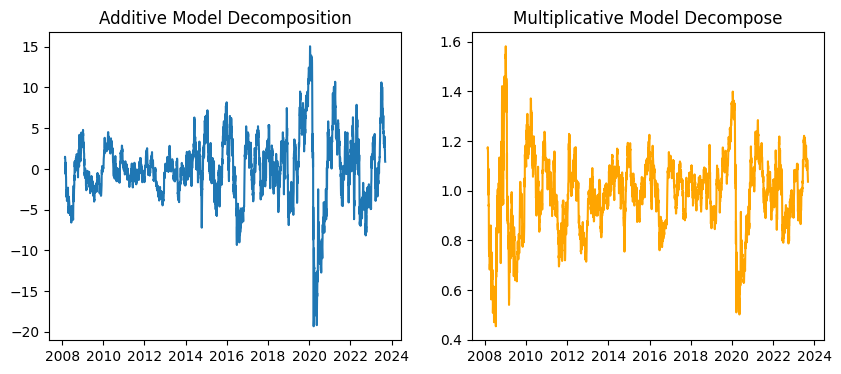

In [79]:
# Understanding Residuals
result_additive = sm.tsa.seasonal_decompose(df['Close'], model="additive", period=365)
result_multiplicative = sm.tsa.seasonal_decompose(df['Close'], model="multiplicative", period=365)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(result_additive.resid)
ax[0].set_title("Additive Model Decomposition")
ax[1].plot(result_multiplicative.resid, color="orange")
ax[1].set_title("Multiplicative Model Decompose")
plt.show()

The graphs shows mean is 0 for additive model and 1 for multiplicative model. The standard deviation is not constant though. And again, correlation is visually not zero. So, the time series is not `white-noise`.

*** Strategy Development ***

Now my strategy for this kind of time-series would be to make sure to de-trend the time-series first of all. And I have to make it stationary as well. We have seen before that Adjusted Dicky-Fuller shows the time series is non-stationary.

task 1: To make it stationary, we need to just do general differencing. Seasonal differencing will not be needed according to primary inspection. Again, we will do a short inspection if that is needed will be performed.

task 2: To de-trend it, I have to apply seasonal differencing.


#### Data Preparation

Lets have a look at our current data

In [80]:
df.head()

,Close,Volume
Date,,
2007-06-01,16.945208,2299400.0
2007-06-04,16.329809,5692700.0
2007-06-05,16.425148,4510000.0
2007-06-06,16.407816,2595300.0
2007-06-07,16.017773,3062100.0


Lets drop the Volume column

In [81]:
# first drop the Volumes
df.drop(columns=["Volume"], inplace=True, errors="ignore")
df.shape

(4280, 1)

Now create a one lagged Close column Close_(t) - Close_(t-1)

In [82]:
lagged = df['Close'] - df['Close'].shift(1)
lagged.head()

Date
2007-06-01         NaN
2007-06-04   -0.615398
2007-06-05    0.095339
2007-06-06   -0.017332
2007-06-07   -0.390043
Name: Close, dtype: float64

Lets see the graph for Returns

So we can see there is at least one NaN value. Lets see how many more are there.

In [83]:
print(f"There is/are only {int(lagged.isna().sum())} NaN(s)")

There is/are only 1 NaN(s)


Lets handle that NaN

In [84]:
lagged = lagged.fillna(0)
lagged.head()

Date
2007-06-01    0.000000
2007-06-04   -0.615398
2007-06-05    0.095339
2007-06-06   -0.017332
2007-06-07   -0.390043
Name: Close, dtype: float64

Lets put it on the OneLagged column and save it

In [85]:
df["OneLagged"] = lagged
df.head()

,Close,OneLagged
Date,,
2007-06-01,16.945208,0.000000
2007-06-04,16.329809,-0.615398
2007-06-05,16.425148,0.095339
2007-06-06,16.407816,-0.017332
2007-06-07,16.017773,-0.390043


<Axes: title={'center': 'Returns'}, xlabel='Date'>

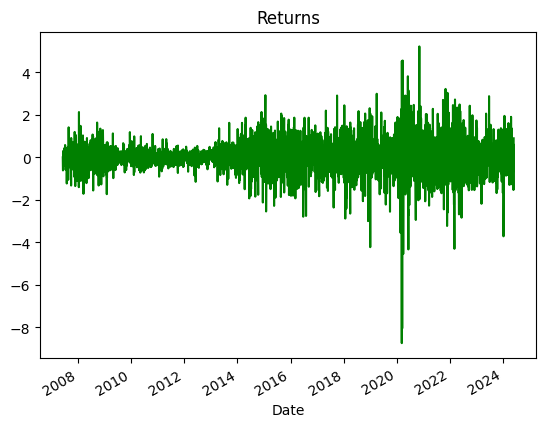

In [86]:
df['OneLagged'].plot(color="green", title="Returns")

As we can see above, the returns one lagged version makes more sense as a detrend version of the dataset.

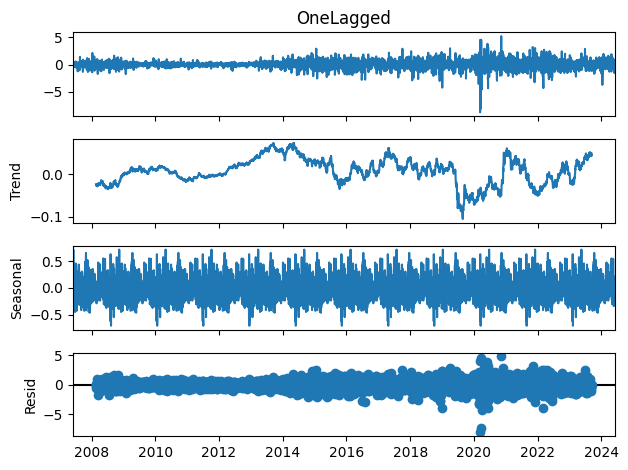

In [87]:
result_additive = sm.tsa.seasonal_decompose(df['OneLagged'], model="additive", period=365)
result_additive.plot()
plt.show()

As the above graph suggests, the time-series now cannot be identified as up trend or down trend. The line is now haphazard. And we cannot think of a multiplicative 

Now we can go ahead with this dataset. Let's save it in the folder.

In [88]:
df.to_csv('../data/dal_one_lagged.csv')

#### Step 2: Start Developing the Model

Before getting to start building our model, we must have some tools in our hand already. We need something to understand if our model is either underfitting or overfitting, we also need something to compare across our models and we must need a tool that can help us with benchmarking our model.
But before all of that we need a tool to separate train and test dataset.

Split our time series into `train` and `test` part. We will use test for testing as the name suggests.

In [90]:
train_test_split_pct    = 0.8 # 80% train and 20% test
break_point             = int(0.8*df.shape[0])
train_df                = df[:break_point]
test_df                 = df[break_point:]
df_rows                 = df.shape[0]
train_df_rows           = train_df.shape[0]
test_df_rows            = test_df.shape[0]
equality_check          = "pass" if train_df_rows + test_df_rows == df_rows else "fail"
print(tabulate([{
    "df_rows": df_rows,
    "train_df_rows": train_df_rows,
    "test_df_rows": test_df_rows,
    "equality_check": equality_check 
}], headers="keys", tablefmt="pretty"))

+---------+---------------+--------------+----------------+
| df_rows | train_df_rows | test_df_rows | equality_check |
+---------+---------------+--------------+----------------+
|  4280   |     3424      |     856      |      pass      |
+---------+---------------+--------------+----------------+


We can use log-likelihood analysis for comparing models

In [91]:
def LLR(model1, model2, DF=1):
    restricted = model1.fit().llf # restricted 
    unrestricted = model2.fit().llf # unrestricted
    LR = 2*(restricted - unrestricted)
    return LR, chi2.sf(LR, DF).round(3)
def explain_llr(result):
    log_statistic, p_value = result
    return tabulate([{
        "log_statistic": log_statistic,
        "P-Value": p_value,
        "significant?": "yes" if p_value < 0.05 else "no"
    }], headers="keys")

Here, we are using one of the joint tests, LLR gives us both LR and P-Value,
if LR is greater and p-value is smaller that means unrestricted model is best.

In [66]:
from itertools import product
AR_base = sm.tsa.arima.ARIMA(train_df['OneLagged'], order=(1, 0, 1))
LR_array = []
P_Value_array = []
iteration = 1
for q in range(11):
    for p in range(11):
        print(f"p = {p} q = {q}")
        AR_high = sm.tsa.arima.ARIMA(train_df['OneLagged'], order=(p, 0, q))
        result = LLR(AR_high, AR_base, abs(p-q))
        LR_array.append(result[0])
        P_Value_array.append(result[1])
        print(f"----Interation {iteration} ------")
        print(explain_llr(result))
        iteration += 1

p = 0 q = 0
----Interation 1 ------
  log_statistic    P-Value  significant?
---------------  ---------  --------------
       -5.02638        nan  no
p = 1 q = 0
----Interation 2 ------
  log_statistic    P-Value  significant?
---------------  ---------  --------------
     -0.0392599          1  no
p = 2 q = 0
----Interation 3 ------
  log_statistic    P-Value  significant?
---------------  ---------  --------------
      0.0316349      0.984  no
p = 3 q = 0
----Interation 4 ------
  log_statistic    P-Value  significant?
---------------  ---------  --------------
       0.905966      0.824  no
p = 4 q = 0
----Interation 5 ------
  log_statistic    P-Value  significant?
---------------  ---------  --------------
        1.45849      0.834  no
p = 5 q = 0
----Interation 6 ------
  log_statistic    P-Value  significant?
---------------  ---------  --------------
        3.88139      0.567  no
p = 6 q = 0
----Interation 7 ------
  log_statistic    P-Value  significant?
---------------  

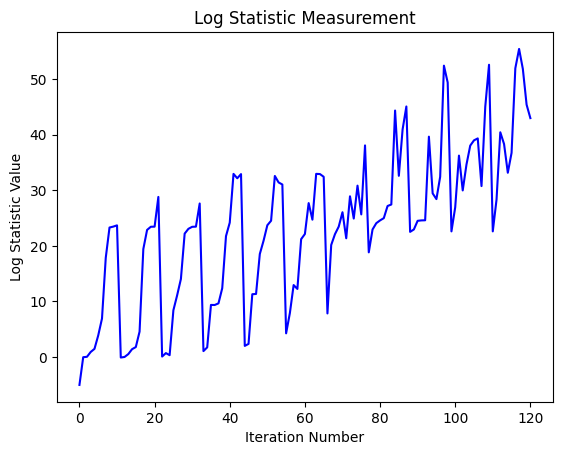

In [67]:
# Lets see Log statistic
plt.plot(LR_array, color="blue")
plt.ylabel("Log Statistic Value")
plt.xlabel("Iteration Number")
plt.title("Log Statistic Measurement")
plt.show()

As we can see the log statistic will go only higher and higher if the model is quite complex. We must find a sweet spot where we can rely.
As the graph shows, we can take any order which results Log Statistic to be in between 80 to 110 but P_value must be must be near zero.

Lets see the P_value chart

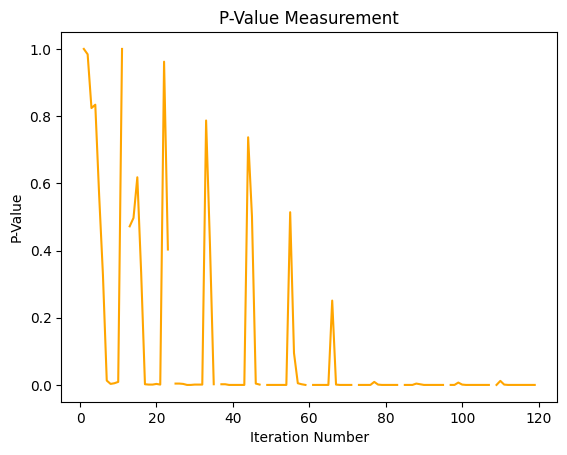

In [68]:
plt.plot(P_Value_array, color="orange")
plt.ylabel("P-Value")
plt.xlabel("Iteration Number")
plt.title("P-Value Measurement")
plt.show()

As the graph shows, we can take orders from 80 onwards to have a decent model.

Lets see ACF and PACF plots for the `Close` data.

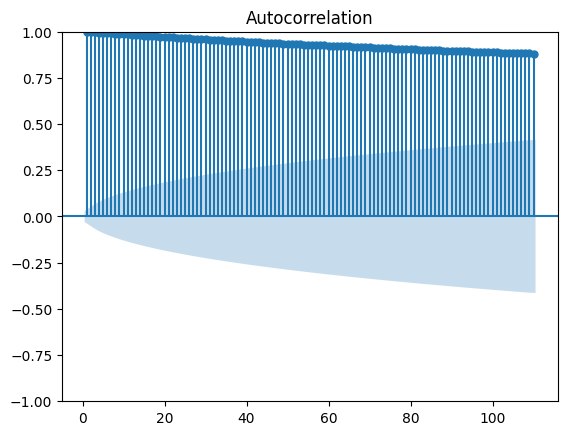

In [92]:
plot_acf(df["Close"], lags=110, zero=False)
plt.show()

As expected it is near one for all the observations

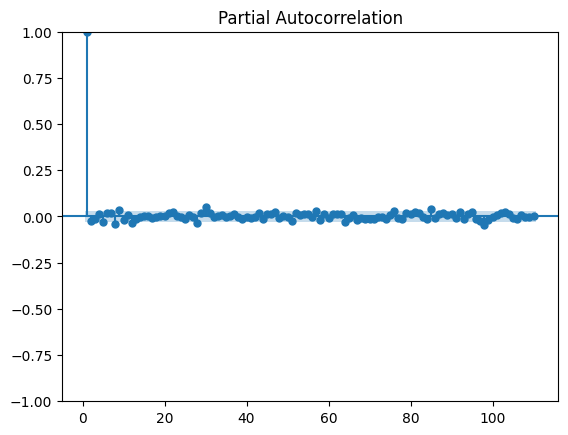

In [93]:
plot_pacf(df["Close"], zero=False, lags=110)
plt.show()

As we can see, we have decent 80 lags. So, till last 80 days we have a pattern it suggests. But the pattern is not that strong as it actually dips down quite often.

#### Lets Try Using ARMA model first

In [119]:
ARMA = sm.tsa.arima.ARIMA(train_df['OneLagged'], order=(9, 0, 10))

In [120]:
arma = ARMA.fit()

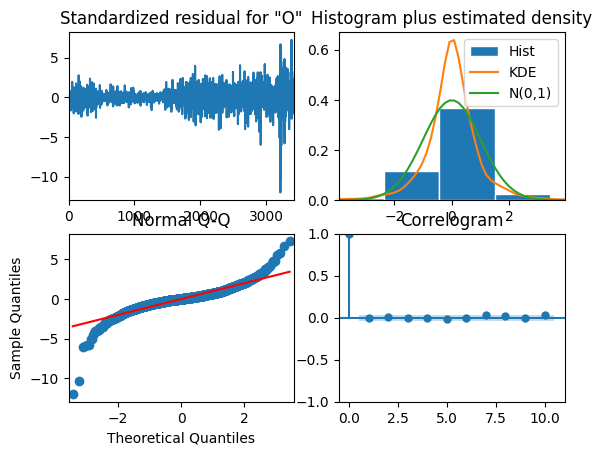

In [121]:
arma.plot_diagnostics()
plt.show()

In [122]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              OneLagged   No. Observations:                 3424
Model:                ARIMA(9, 0, 10)   Log Likelihood               -3662.549
Date:                Sat, 04 Oct 2025   AIC                           7367.098
Time:                        16:58:21   BIC                           7496.008
Sample:                             0   HQIC                          7413.156
                               - 3424                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.013      0.495      0.621      -0.019       0.032
ar.L1          0.4708      0.419      1.124      0.261      -0.350       1.292
ar.L2          0.8908      0.419      2.123      0.034       0.069       1.713
ar.L3         -0.9107      0.198     -4.602      0.000      -1.299      -0.523
ar.L4          0.0271      0.350      0.077      0.938      -0.659       0.713
ar.L5          0.7838      0.175      4.472      0.000       0.440       1.127
ar.L6         -0.5649      0.277     -2.036      0.042      -1.109      -0.021
ar.L7         -0.5663      0.317     -1.787      0.074      -1.187       0.055
ar.L8          0.5445      0.151      3.612      0.000       0.249       0.840
ar.L9          0.2874      0.261      1.101      0.271      -0.224       0.799
ma.L1         -0.4288      0.420     -1.021      0.307      -1.252       0.394
ma.L2         -0.9113      0.400     -2.276      0.023      -1.696      -0.127
ma.L3          0.8667      0.201      4.314      0.000       0.473       1.261
ma.L4          0.0360      0.339      0.106      0.915      -0.628       0.700
ma.L5         -0.8009      0.159     -5.028      0.000      -1.113      -0.489
ma.L6          0.4845      0.284      1.704      0.088      -0.073       1.042
ma.L7          0.6650      0.298      2.229      0.026       0.080       1.250
ma.L8         -0.5636      0.174     -3.240      0.001      -0.905      -0.223
ma.L9         -0.3535      0.280     -1.262      0.207      -0.903       0.195
ma.L10         0.0421      0.019      2.230      0.026       0.005       0.079
sigma2         0.4988      0.006     85.301      0.000       0.487       0.510
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             30821.31
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               6.24   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [123]:
forecast = arma.forecast(steps=len(test_df))
forecast.shape

(856,)

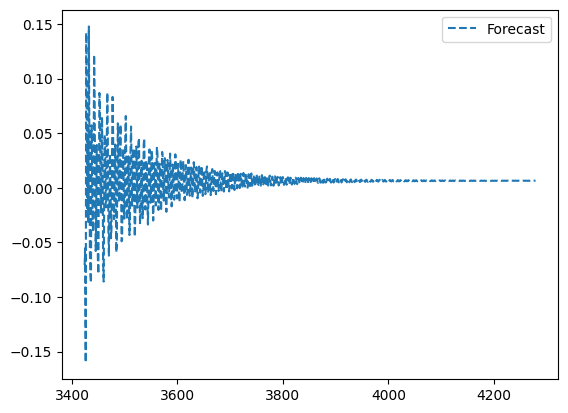

In [124]:
forecast.plot(label='Forecast', style='--')
plt.legend()
plt.show()

In [ ]:
forecast_array = [train_df['Close'][-1]]
for i in range(len(train_df), len(train_df)+len(test_df)):
    forecast_array.append(forecast_array[-1] + forecast[i])


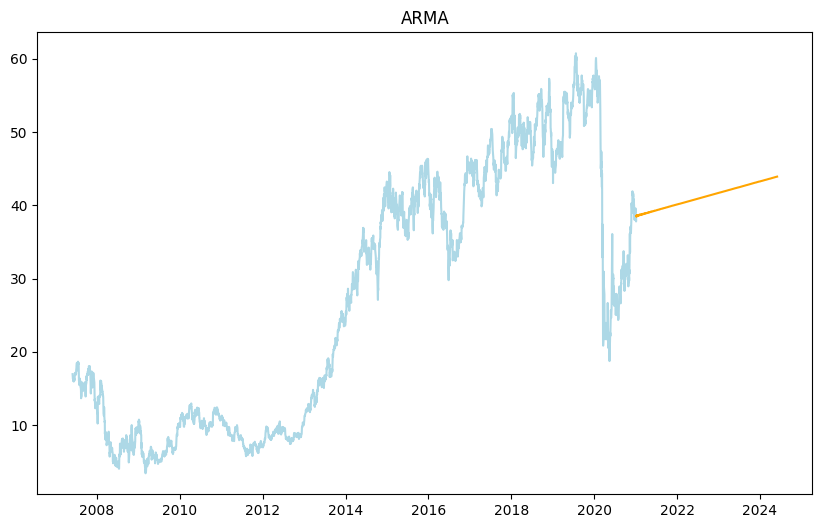

In [162]:
plt.figure(figsize=(10, 6))
plt.title("ARMA")
plt.plot(train_df.index, train_df['Close'], color="lightblue")
plt.plot(test_df.index, forecast_array[1:], color="orange")
plt.show()

Visually, We can see the ARMA model is not that good predictor as it just shows a steep line.

#### Lets Find Out the RMSE and R2 for ARMA

In [150]:
rmse = np.sqrt(mean_squared_error(test_df['Close'], forecast_array[1:]))
print(f'RMSE: {rmse:.2f}')

RMSE: 6.19


Its Very High, model is not recommended if there is more to find

In [152]:
r_squared = r2_score(test_df['Close'], forecast_array[1:])
print(f'R-squared: {r_squared:.2f}')

R-squared: -0.32


This suggests the ARMA model is poor.

#### Lets Try our luck with ARIMA

As we have a one difference model so d = 1 here.

In [146]:
ARIMA = sm.tsa.arima.ARIMA(train_df['OneLagged'], order=(9, 1, 10))

Lets train it

In [147]:
arima = ARIMA.fit()

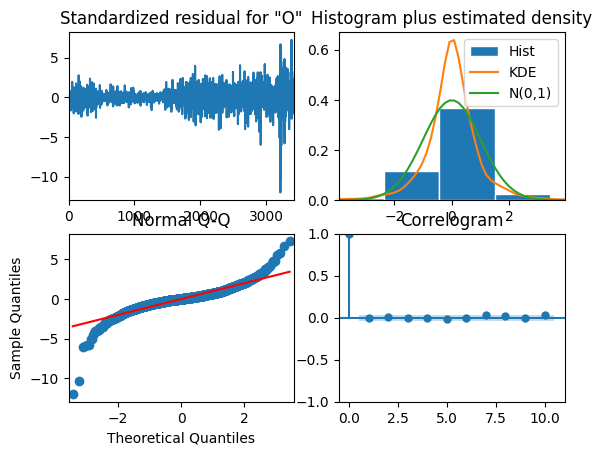

In [153]:
arma.plot_diagnostics()
plt.show()

In [154]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              OneLagged   No. Observations:                 3424
Model:                ARIMA(9, 1, 10)   Log Likelihood               -3671.519
Date:                Sat, 04 Oct 2025   AIC                           7383.037
Time:                        17:24:31   BIC                           7505.803
Sample:                             0   HQIC                          7426.900
                               - 3424                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8149      0.329     -5.516      0.000      -2.460      -1.170
ar.L2         -2.5223      0.513     -4.914      0.000      -3.528      -1.516
ar.L3         -2.8436      0.538     -5.286      0.000      -3.898      -1.789
ar.L4         -3.0773      0.628     -4.904      0.000      -4.307      -1.847
ar.L5         -2.9516      0.639     -4.619      0.000      -4.204      -1.699
ar.L6         -2.5565      0.577     -4.427      0.000      -3.688      -1.425
ar.L7         -1.8597      0.507     -3.671      0.000      -2.853      -0.867
ar.L8         -0.9347      0.353     -2.644      0.008      -1.627      -0.242
ar.L9         -0.3237      0.150     -2.165      0.030      -0.617      -0.031
ma.L1          0.8595      0.329      2.615      0.009       0.215       1.504
ma.L2          0.7505      0.282      2.661      0.008       0.198       1.303
ma.L3          0.3524      0.121      2.913      0.004       0.115       0.589
ma.L4          0.2820      0.117      2.413      0.016       0.053       0.511
ma.L5         -0.1058      0.079     -1.332      0.183      -0.261       0.050
ma.L6         -0.4166      0.089     -4.691      0.000      -0.591      -0.243
ma.L7         -0.6877      0.115     -5.967      0.000      -0.914      -0.462
ma.L8         -0.9736      0.189     -5.147      0.000      -1.344      -0.603
ma.L9         -0.6685      0.263     -2.544      0.011      -1.184      -0.153
ma.L10        -0.3906      0.156     -2.500      0.012      -0.697      -0.084
sigma2         0.4990      0.007     71.726      0.000       0.485       0.513
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             32647.46
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               6.26   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
forecast = arima.forecast(steps=len(test_df))
forecast.shape

(856,)

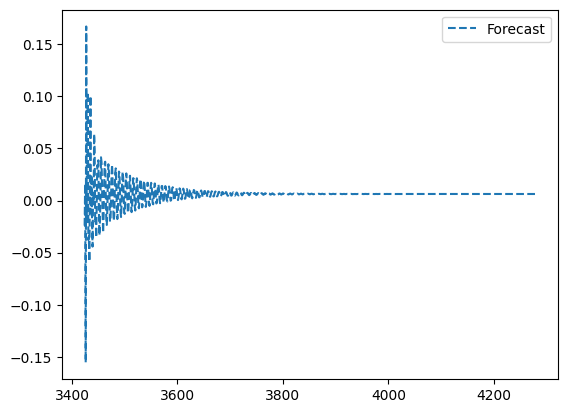

In [156]:
forecast.plot(label='Forecast', style='--')
plt.legend()
plt.show()

In [157]:
forecast_array = [train_df['Close'][-1]]
for i in range(len(train_df), len(train_df)+len(test_df)):
    forecast_array.append(forecast_array[-1] + forecast[i])

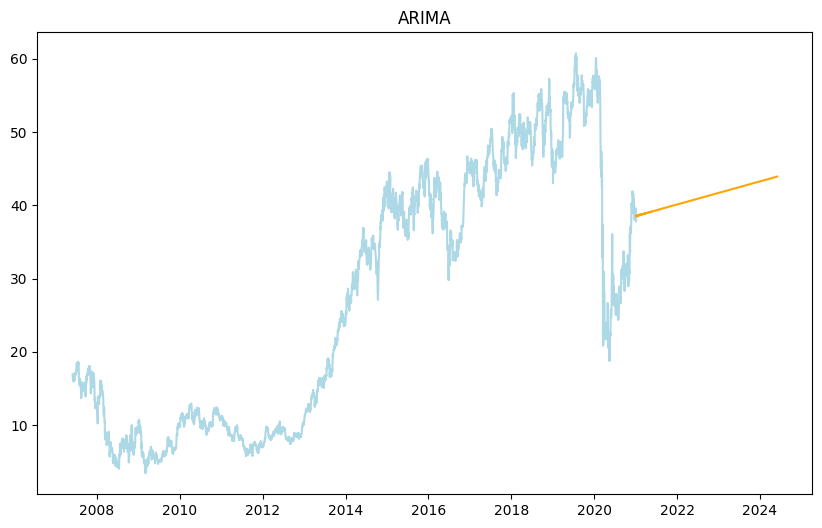

In [161]:
plt.figure(figsize=(10, 6))
plt.title("ARIMA")
plt.plot(train_df.index, train_df['Close'], color="lightblue")
plt.plot(test_df.index, forecast_array[1:], color="orange")
plt.show()

#### Lets Find Out the RMSE and R2 for ARIMA

In [159]:
rmse = np.sqrt(mean_squared_error(test_df['Close'], forecast_array[1:]))
print(f'RMSE: {rmse:.2f}')

RMSE: 6.25


In [160]:
r_squared = r2_score(test_df['Close'], forecast_array[1:])
print(f'R-squared: {r_squared:.2f}')

R-squared: -0.34
